# Histopathologic Cancer Detection (Kaggel Project)

## Load data for Google Colab

In [1]:
import os
print(os.listdir('/content'))

['.config', 'sample_submission.csv', 'train_labels.csv', 'train', 'test', 'drive', 'histopathologic-cancer-detection.zip', 'sample_data']


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = '/content/drive/MyDrive/DTSA-Project/'
drive_contents = os.listdir(path)
drive_contents

['sample_submission.csv',
 'histopathologic-cancer-detection.zip',
 'train_labels.csv',
 'histopathologic-cancer-detection',
 'final-project.ipynb']

In [4]:
import shutil

# Copy the file from Google Drive to Colab
source_path = path + 'histopathologic-cancer-detection.zip'
destination_path = '/content/histopathologic-cancer-detection.zip'

shutil.copy(source_path, destination_path)
print("File copied successfully.")

File copied successfully.


In [5]:
import zipfile

# Unpack zip file
destination_folder = '/content/'
with zipfile.ZipFile(destination_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

print("Zip file extracted successfully.")

Zip file extracted successfully.


## Imports and checks

In [6]:
# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, MobileNetV2
from tensorflow.keras.layers import (
    Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision
from tensorflow.keras.models import clone_model

# Keras version check
import keras

# Data handling and utilities
import pandas as pd
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Device management
from tensorflow.python.client import device_lib

In [7]:
# Check Keras version
print(keras.__version__)

# Check Tensorflow version
print(tf.__version__)

# Check GPU
print(device_lib.list_local_devices())
print(tf.config.list_physical_devices('GPU'))

3.5.0
2.17.1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13894386042046810778
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 40427651072
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5293998613417773980
physical_device_desc: "device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0"
xla_global_id: 416903419
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Step 1: Brief description of the problem and data

### Problem Description
The goal of this project is to train a model that is capable of identifying metastatic cancer in small image patches taken from larger digital pathology scans [1].

### Data
The PatchCamelyon (PCam) benchmark is an image classification dataset containing 327,680 96x96 color images from histopathologic lymph node scans, each labeled with a binary indication of metastatic tissue. It serves as a middle-ground benchmark for machine learning models, larger than CIFAR-10 but smaller than ImageNet, and is trainable on a single GPU. It has been slightly modified for Kaggle. [1], [2]

## Step 2: EDA

Sample images and class distribution.

### Load labels and connect to file names

In [8]:
path = '/content/'

# Load the CSV
labels_df = pd.read_csv(path + 'train_labels.csv')
labels_df['label'] = labels_df['label'].astype(str)

# Add extension and path
labels_df['filename'] = labels_df['id'].apply(lambda x: x + '.tif')
image_dir = path + 'train'
labels_df['filepath'] = labels_df['filename'].apply(lambda x: os.path.join(image_dir, x))

labels_df.head()

,id,label,filename,filepath
0,f38a6374c348f90b587e046aac6079959adf3835,0,f38a6374c348f90b587e046aac6079959adf3835.tif,/content/train/f38a6374c348f90b587e046aac60799...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,/content/train/c18f2d887b7ae4f6742ee445113fa1a...
2,755db6279dae599ebb4d39a9123cce439965282d,0,755db6279dae599ebb4d39a9123cce439965282d.tif,/content/train/755db6279dae599ebb4d39a9123cce4...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,/content/train/bc3f0c64fb968ff4a8bd33af6971eca...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,068aba587a4950175d04c680d38943fd488d6a9d.tif,/content/train/068aba587a4950175d04c680d38943f...


In [9]:
labels_df.shape

(220025, 4)

The table with the training labels consists of 220,025 rows and 2 columns. After adding the file names and file paths for further processing, the DataFrame has 4 columns. The 'train' folder contains one image per row, while the 'test' folder holds test images for which labels need to be predicted for the competition.

### Sample Images

Found 100 validated image filenames belonging to 2 classes.


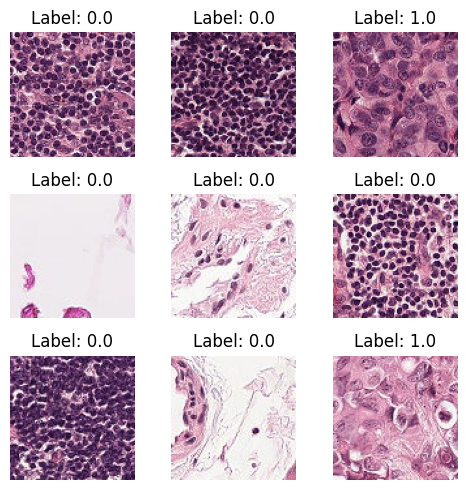

In [10]:
labels_df_sample = labels_df.sample(n=100)

# Load images and labels
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=labels_df_sample,
    x_col='filepath',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

# Plot sample images
images, labels = next(train_generator)

plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


### Class Distribution

<ipython-input-11-8a1195d0f7d1>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=labels_df, palette='hls')


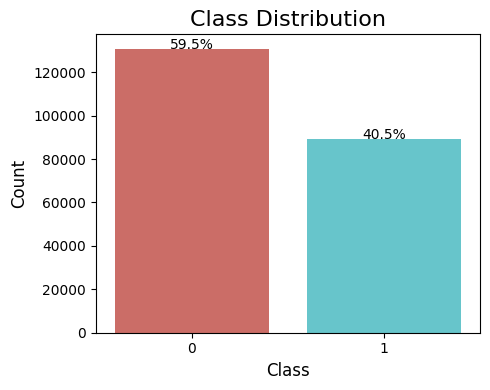

In [11]:
# Percentages
class_counts = labels_df['label'].value_counts(normalize=True) * 100

# Plot histogram with percentages
plt.figure(figsize=(5, 4))
sns.countplot(x='label', data=labels_df, palette='hls')

for p in plt.gca().patches:
    height = p.get_height()
    percentage = (height / len(labels_df)) * 100
    plt.text(p.get_x() + p.get_width() / 2., height - 5, f'{percentage:.1f}%',
             ha='center', fontsize=10)

# Plot
plt.title('Class Distribution', fontsize=16)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)

plt.tight_layout()
plt.show()


### EDA Conclusion
- There are two class labels: 0 and 1.
- The data is not perfectly balanced but is also not highly skewed; therefore, no action is required.
- Paths and filenames have been added for further processing.
- Next steps: Create a model to predict labels based on the images.

## Step 3: Model Architecture

### (Small) CNN from scratch
The convolutional layers (32, 64, 128 filters) progressively extract features from the images, with BatchNormalization and MaxPooling2D helping to stabilize training and reduce size. The fully connected layers, with dropout for regularization, make the final predictions, and the sigmoid output layer provides binary classification results.

- Convolutional Layers:
  - Conv2D: 32 filters, kernel size (3, 3), ReLU activation, followed by BatchNormalization and MaxPooling2D with pool size (2, 2).
  - Conv2D: 64 filters, kernel size (3, 3), ReLU activation, followed by BatchNormalization and MaxPooling2D with pool size (2, 2).
  - Conv2D: 128 filters, kernel size (3, 3), ReLU activation, followed by BatchNormalization and MaxPooling2D with pool size (2, 2).
  
- Fully Connected Layers:
  - Flatten: Flatten the 3D output of the convolutional layers to 1D.
  - Dense: 128 units, ReLU activation.
  - Dropout: 50% regularization to prevent overfitting.
  - Dense: 1 unit, Sigmoid activation for binary classification output.

- Output Layer: A binary classification output (0 or 1).

### Transfer learning: MobileNetV2 with custom classification layers
Considering the size of the dataset and the limited GPU resources available for this project, transfer learning was chosen as an additional method. MobileNetV2 was chosen as base model due to resource limitations.

The following custom layers were added:
- GlobalAveragePooling2D: Reduces the dimensionality by averaging the feature map across spatial dimensions (height and width).
- Dropout Layer 1: Dropout rate of 20% to prevent overfitting by randomly setting a fraction of input units to zero during training.
- Dense Layer with ReLU activation: 128 units with ReLU activation, allowing the model to learn more complex patterns.
- Dropout Layer 2: Dropout rate of 20% to further prevent overfitting.
- Output Layer: A single unit with sigmoid activation, used for binary classification (outputting a value between 0 and 1).

## Step 4: Results and Analysis

### Data generators

In [12]:
# Example Data Generators using flow_from_dataframe
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

# Training data generator
train_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    x_col='filepath',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

# Validation data generator
val_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    x_col='filepath',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


### (Small) CNN from scratch

In [13]:
model_seq = Sequential([
    # Convolutional Layer 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Layer 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Layer 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten and Fully Connected Layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_seq.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'AUC', Precision()]
)

# Summary of the model
model_seq.summary()

# Train the model
history = model_seq.fit(
    train_generator,
    validation_data=val_generator,
    epochs=3,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 94, 94, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 20, 20, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,732,801 (6.61 MB)

 Trainable params: 1,732,353 (6.61 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 646s 116ms/step - AUC: 0.8640 - accuracy: 0.8012 - loss: 0.5152 - precision: 0.7934 - val_AUC: 0.8140 - val_accuracy: 0.7441 - val_loss: 0.6204 - val_precision: 0.7082
Epoch 2/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 6us/step - AUC: 0.0000e+00 - accuracy: 0.0000e+00 - loss: 0.0000e+00 - precision: 0.0000e+00
Epoch 3/3


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 632s 115ms/step - AUC: 0.9262 - accuracy: 0.8580 - loss: 0.3448 - precision: 0.8630 - val_AUC: 0.9165 - val_accuracy: 0.8245 - val_loss: 0.3770 - val_precision: 0.8605


### (Small) CNN from scratch: hyperparameter tuning

The hyperparameter tuning approach involves different combinations of learning rates, dropout rates, and batch sizes to identify the optimal set for the model. Specifically, the learning rates tested are 0.01, and 0.001; dropout rates of 0.3, and 0.5; and batch sizes of 32, and 128.

In [14]:
# Parameter ranges
learning_rates = [0.01, 0.001]
dropout_rates = [0.3, 0.5]
batch_sizes = [32, 128]

# Model Tracking
best_val_acc = 0
best_model = None
best_history = None

# Collect history
histories = []

for lr in learning_rates:
    for dropout in dropout_rates:
        for batch_size in batch_sizes:

            model_seq_hyper = Sequential([
                # Convolutional Layer 1
                Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
                BatchNormalization(),
                MaxPooling2D(pool_size=(2, 2)),

                # Convolutional Layer 2
                Conv2D(64, (3, 3), activation='relu'),
                BatchNormalization(),
                MaxPooling2D(pool_size=(2, 2)),

                # Convolutional Layer 3
                Conv2D(128, (3, 3), activation='relu'),
                BatchNormalization(),
                MaxPooling2D(pool_size=(2, 2)),

                # Flatten and Fully Connected Layers
                Flatten(),
                Dense(128, activation='relu'),
                Dropout(dropout),
                Dense(1, activation='sigmoid')
            ])

            # Recompile
            model_seq_hyper.compile(
                optimizer=Adam(learning_rate=lr),
                loss='binary_crossentropy',
                metrics=['accuracy', 'AUC', Precision()]
            )

            # Train model
            print(f"Training with learning_rate={lr}, dropout={dropout}, batch_size={batch_size}...")
            history = model_seq_hyper.fit(
                train_generator,
                validation_data=val_generator,
                epochs=2,
                steps_per_epoch=len(train_generator),
                validation_steps=len(val_generator),
                batch_size=batch_size
            )

            histories.append(history)

            val_acc = max(history.history['val_accuracy'])
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model = model_seq_hyper
                best_history = history

print(f"Best model validation accuracy: {best_val_acc}")

Training with learning_rate=0.01, dropout=0.3, batch_size=32...
Epoch 1/2
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 640s 115ms/step - AUC: 0.7979 - accuracy: 0.7301 - loss: 1.1517 - precision_1: 0.6935 - val_AUC: 0.8864 - val_accuracy: 0.8145 - val_loss: 0.4831 - val_precision_1: 0.9023
Epoch 2/2
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 6us/step - AUC: 0.0000e+00 - accuracy: 0.0000e+00 - loss: 0.0000e+00 - precision_1: 0.0000e+00
Training with learning_rate=0.01, dropout=0.3, batch_size=128...
Epoch 1/2
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 639s 115ms/step - AUC: 0.8210 - accuracy: 0.7660 - loss: 1.3296 - precision_2: 0.7922 - val_AUC: 0.7922 - val_accuracy: 0.6853 - val_loss: 0.9352 - val_precision_2: 0.8907
Epoch 2/2
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 6us/step - AUC: 0.0000e+00 - accuracy: 0.0000e+00 - loss: 0.0000e+00 - precision_2: 0.0000e+00
Training with learning_rate=0.01, dropout=0.5, batch_size=32...
Epoch 1/2
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 642s 116ms/step - AUC: 0.7609 - accuracy: 0.7132 - loss: 1.432

### MobileNetV2 with custom classification layers

In [15]:
input_shape = (96, 96, 3)

# Load pre-trained MobileNetV2 model
base_model = MobileNetV2(include_top=False, weights='imagenet',
                         input_shape=input_shape)

# Freeze base model (no fine tuning)
base_model.trainable = False

# Custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

# Defien and compile the model
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy', 'AUC', Precision()])

model.summary()

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=3,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9             │ (None, 96, 96, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 48, 48, 32)     │            864 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 48, 48, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 48, 48, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 48, 48, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 48, 48, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 48, 48, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 48, 48, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 48, 48, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 48, 48, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 48, 48, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 48, 48, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 49, 49, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 24, 24, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 661s 118ms/step - AUC: 0.8898 - accuracy: 0.8171 - loss: 0.4059 - precision_9: 0.7982 - val_AUC: 0.9275 - val_accuracy: 0.8536 - val_loss: 0.3338 - val_precision_9: 0.8531
Epoch 2/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 0s 10us/step - AUC: 0.0000e+00 - accuracy: 0.0000e+00 - loss: 0.0000e+00 - precision_9: 0.0000e+00
Epoch 3/3
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 640s 116ms/step - AUC: 0.9175 - accuracy: 0.8448 - loss: 0.3538 - precision_9: 0.8361 - val_AUC: 0.9298 - val_accuracy: 0.8487 - val_loss: 0.3419 - val_precision_9: 0.7909


### Prediction using the small custom CNN

In [16]:
# DataFrame for the test images
test_folder = path + 'test'
test_files = os.listdir(test_folder)
test_df = pd.DataFrame({
    'filepath': [os.path.join(test_folder, file) for file in test_files],
    'id': [file.split('.')[0] for file in test_files]
})

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col=None,
    target_size=(96, 96),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 57458 validated image filenames.


In [17]:
# Predict classes for the test set
predictions = best_model.predict(test_generator, verbose=1)
labels = (predictions > 0.5).astype(int).flatten()

# Save to CSV
test_df['label'] = labels
submission = test_df[['id', 'label']]
submission.to_csv("submission.csv", index=False)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 44s 24ms/step


In [19]:
shutil.copy('submission.csv', 'drive/MyDrive/DTSA-Project/submission.csv')
print("File copied successfully.")

File copied successfully.


## Step 5: Conclusion

In this project, two modeling approaches were used to identify metastatic cancer in small image patches: 1) a small custom CNN and 2) transfer learning (with fixed weights) combined with custom layers. Both models performed reasonably well, achieving validation accuracy scores of approximately 0.85. To further improve the performance of the custom CNN, hyperparameter tuning was applied. However, this did not lead to substantial improvements. The best custom model achieved an accuracy score of 0.87, AUC of 0.94, and precision of 0.87. The custom CNN's performance was comparable to the second approach (transfer learning), likely because the training data contained a sufficiently large number of images.

To further enhance the model, one potential approach is to use a larger base model, as demonstrated by [3], where ResNet was used alongside a single neuron layer with a sigmoid activation. This was not attempted in this project due to hardware limitations (I’m working on an RTX 3050 Laptop GPU and Google Colab's free T4 ;)). EDA could also be improved by analyzing RGB channel intensities, as there appears to be a correlation between the green channel's intensity and the occurrence of cancer (as demonstrated by [4]).

## References
[1] Veeling, B. (n.d.). *PatchCamelyon (PCam) benchmark dataset*. GitHub. Retrieved January 5, 2025, from [https://github.com/basveeling/pcam](https://github.com/basveeling/pcam)

[2] Kaggle. (n.d.). *Histopathologic cancer detection*. Retrieved January 5, 2025, from [https://www.kaggle.com/c/histopathologic-cancer-detection/overview](https://www.kaggle.com/c/histopathologic-cancer-detection/overview)

[3] Azkalot1. (n.d.). *Histopathologic Cancer Detection*. GitHub. Retrieved January 5, 2025, from https://github.com/azkalot1/Histopathologic-Cancer-Detection/tree/master

[4] Pietka, T. (n.d.). *BS-SM-TP-HCD Visualizations*. Kaggle. Retrieved January 5, 2025, from https://www.kaggle.com/code/terripietka/bs-sm-tp-hcd-visualizations